In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

from PIL import Image

torch.backends.cudnn.benchmark = True

/home/seham/miniconda3/envs/blockies-xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [2]:
CLASSES = ['Healthy', 'OC Degeneration']

load_checkpoints = True

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

# Setup and Load Datasets

In [3]:
relative_model_path = "two4two_sickones_models_pytorch"
base_path = Path('./') / relative_model_path
base_path

PosixPath('two4two_sickones_models_pytorch')

In [4]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)

  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(str(self.data_dir), str(self.df.iloc[idx]['filename'])) ## Added str 
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [26]:

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    elif archive_folder is not None and (Path(cache_dir) / archive_folder).exists():
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    else:
      return Path(cache_dir)

    return Path(file_path)

In [27]:
data_dir = download_file("https://uni-bielefeld.sciebo.de/s/2BgY19ixIaEUOmS/download",
                         "two4two_datasets.tar.gz",
                         cache_dir='data',
                         extract=False,
                         force_download=False,
                         archive_folder='two4two_datasets')

ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

File already exists at: data/two4two_datasets.tar.gz


(PosixPath('data/two4two_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('data/two4two_datasets/sick_ones_bendbias_v3_2class_variation'))

In [28]:
train_df = load_dataframe(ds_dir, 'train')
train_transforms = T.Compose([
    T.ToTensor()
])
train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=train_transforms)
dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True,
                        num_workers=6, pin_memory=True)

# Initialize variables to calculate mean
mean = torch.zeros(3)  # For RGB channels
total_pixels = 0

# Loop through the dataset
for images, _ in tqdm(dataloader):
    # Sum pixel values per channel
    mean += images.sum(dim=[0, 2, 3])
    total_pixels += images.size(0) * images.size(2) * images.size(3)

# Divide by total number of pixels
mean /= total_pixels

print(f"Mean per channel: {mean}")

# Initialize variables for std calculation
std = torch.zeros(3)

# Loop again for standard deviation
for images, _ in tqdm(dataloader):
    std += ((images - mean.view(1, 3, 1, 1))**2).sum(dim=[0, 2, 3])

std = torch.sqrt(std / total_pixels)

print(f"Standard Deviation per channel: {std}")

100%|██████████| 400/400 [00:10<00:00, 38.93it/s]


Mean per channel: tensor([0.8068, 0.7830, 0.8005])


100%|██████████| 400/400 [00:11<00:00, 34.49it/s]

Standard Deviation per channel: tensor([0.1093, 0.1136, 0.1029])


In [29]:
train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')

In [30]:
len(val_df), len(test_df), len(eval_df), len(train_df)

(1000, 3000, 3000, 40000)

In [31]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [32]:
test_df['filename'] = test_df['filename'].astype(str).str.strip()
for i, fname in enumerate(test_df['filename']):
    if '\n' in fname or ' ' in fname:
        print(f"[WARNING] Bad filename in row {i}: {repr(fname)}")

In [33]:
train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

train_eval_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_eval_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False,
                                   num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

In [34]:
data_ex = next(iter(train_dataloader))
data_ex[0].shape, data_ex[1].shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

## Analysis Dataset

In [35]:
# create column for absolute sphere difference
train_df['sphere_diff'] = np.abs(train_df['spherical'] - train_df['ill_spherical'])
val_df['sphere_diff'] = np.abs(val_df['spherical'] - val_df['ill_spherical'])
test_df['sphere_diff'] = np.abs(test_df['spherical'] - test_df['ill_spherical'])
eval_df['sphere_diff'] = np.abs(eval_df['spherical'] - eval_df['ill_spherical'])

# Model Training and Evaluation

In [36]:
def load_resnet50(num_classes, pretrained=True, checkpoint_path=None):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final fully-connected layer

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from: {checkpoint_path}")

    return model

In [37]:
# setup model path
model_path = base_path / ds / f'{modeltype}'
model_path.mkdir(parents=True, exist_ok=True)
print("Model path:", model_path)

Model path: two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet


In [38]:
# setup checkpoint folders
checkpoint_path = model_path / "torch_resnet50/"
(checkpoint_path / 'tmp').mkdir(parents=True, exist_ok=True)
(checkpoint_path / 'final').mkdir(parents=True, exist_ok=True)

In [39]:
# Define loss function
criterion = nn.CrossEntropyLoss()
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
device

device(type='cuda')

In [41]:
# load best model and evaluate

model = load_resnet50(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path / 'final' / 'best_model.pth')
model.to(device)

Loaded checkpoint from: two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet/torch_resnet50/final/best_model.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Similarity explanations

 Given an input image of interest, the similarity explanation method used here aims to find images in the training dataset that are similar to the image of interest according to “how the model sees them”, meaning that the similarity metric makes use of the gradients of the model’s loss function with respect to the model’s parameters. The explanation should be interpreted along the line of “I classify this image as a 1 because I find it similar to another image in the training set that was labeled as a 1.”

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from torch.nn.functional import cross_entropy
from alibi.explainers import GradientSimilarity

In [43]:
# Define inverse normalization using training stats
mean = [0.8068, 0.7830, 0.8005]
std = [0.1093, 0.1136, 0.1029]

inv_normalize = T.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
# Convert tensor to numpy image after inverse normalization
def tensor_to_image(tensor):
    if isinstance(tensor, np.ndarray):
        tensor = torch.tensor(tensor)
    tensor = inv_normalize(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).cpu().numpy()

In [44]:
def predict_fn(x: np.ndarray) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(x).to(device)
        logits = model(x_tensor)
    return logits.cpu().numpy()

# Loss function wrapper for Alibi (must take logits and one-hot labels)
def loss_fn(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    return cross_entropy(logits, labels.argmax(dim=1))

In [45]:
# Use a subset of train dataset as reference
ref_loader = DataLoader(train_dataset, batch_size=10, shuffle=True) #Please change the batch size to 1000
x_ref, y_ref = next(iter(ref_loader))
x_ref = x_ref[:100].numpy().astype('float32')
y_ref = F.one_hot(y_ref[:100], num_classes=len(CLASSES)).numpy().astype('float32')

# Use a few test samples
x_query, y_query = next(iter(test_dataloader))
x_query = x_query[:5].numpy().astype('float32')
y_query = F.one_hot(y_query[:5], num_classes=len(CLASSES)).numpy().astype('float32')


In [46]:
explainer = GradientSimilarity(
    model.cpu(),
    loss_fn=loss_fn,
    sim_fn='grad_cos',           # cosine similarity
    backend='pytorch',
    task='classification',
    precompute_grads=True
)
explainer

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'pytorch',
              'task_name': 'classification'}
            ,
  'version': '0.9.6'}
)

In [47]:
explainer.fit(x_ref, y_ref)

explanation = explainer.explain(x_query, y_query)

In [48]:
# most similar reference indices for each query
print(explanation.data['ordered_indices'])  # shape: (n_query, n_ref)

# similarity scores
print(explanation.data['scores'])           # shape: (n_query, n_ref)

# top-5 similar per query
top5_idx = explanation.data['ordered_indices'][:, :5]

[[2 6 1 7 9 3 0 4 8 5]
 [1 6 2 7 3 9 4 8 0 5]
 [2 1 6 3 0 7 5 8 9 4]
 [6 1 2 7 9 3 0 4 8 5]
 [5 8 0 9 4 7 3 2 6 1]]
[[ 0.7581457   0.6876261   0.5636803  -0.3358692  -0.43295598 -0.4702604
  -0.49879733 -0.5787028  -0.62160206 -0.6374057 ]
 [ 0.7247436   0.6865671   0.6664336  -0.39655858 -0.4140093  -0.5144318
  -0.5295338  -0.5904137  -0.6341874  -0.7189503 ]
 [ 0.7302277   0.6262484   0.61206275 -0.22052413 -0.4968076  -0.58559996
  -0.66033536 -0.68291414 -0.7648773  -0.77885556]
 [ 0.66454345  0.6524472   0.6407357  -0.32630858 -0.40934592 -0.47083324
  -0.4837604  -0.49169764 -0.5293215  -0.64938873]
 [ 0.76798815  0.69341     0.68793595  0.50281596  0.49284387  0.4547672
   0.40802944 -0.5937839  -0.7083109  -0.73576576]]


In [49]:
device = next(model.parameters()).device  # Get model's actual device
y_query_labels = np.argmax(y_query, axis=1)
y_ref_labels = np.argmax(y_ref, axis=1)
ordered_idx = explanation.data['ordered_indices']  # (n_query, n_ref)

ds = []
for j in range(len(x_query)):
    top_indices = ordered_idx[j][:5]
    x_sim = x_ref[top_indices]
    x_sim_tensor = torch.tensor(x_sim).to(device)

    with torch.no_grad():
        preds_sim = model(x_sim_tensor).argmax(1).cpu().numpy()

    d = {
        'x': x_query[j].transpose(1, 2, 0),  # CHW → HWC
        'y': y_query_labels[j],
        'pred': model(torch.tensor(x_query[j][None, ...]).to(device)).argmax(1).item(),
        'y_sim': y_ref_labels[top_indices],
        'preds_sim': preds_sim
    }
    ds.append(d)


Plot most similar instances

In [50]:
import matplotlib.pyplot as plt

def append_int(num):
    if num > 9 and str(num)[-2] == '1':
        return 'th'
    return {1: 'st', 2: 'nd', 3: 'rd'}.get(num % 10, 'th')
# Plot similar examples
def plot_similar(ds, expls, x_ref, top_k=5, figsize=(20, 20)):
    fig, axes = plt.subplots(len(ds), top_k + 1, figsize=figsize)

    for j, d in enumerate(ds):
        axes[j, 0].imshow(d['x'])
        axes[j, 0].axis('off')
        axes[j, 0].set_title(f"Original\nLabel: {d['y']} - Pred: {d['pred']}")

        for i in range(top_k):
            ref_idx = expls.data['ordered_indices'][j][i]
            most_sim = tensor_to_image(x_ref[ref_idx])
            axes[j, i + 1].imshow(most_sim)
            axes[j, i + 1].axis('off')
            axes[j, i + 1].set_title(f"{i+1}{append_int(i+1)} Similar\nLabel: {d['y_sim'][i]} - Pred: {d['preds_sim'][i]}")

    plt.tight_layout()
    plt.show()


In [51]:
# Build ds for plotting from explanation
device = next(model.parameters()).device
ordered_idx = explanation.data['ordered_indices']
y_query_labels = np.argmax(y_query, axis=1)
y_ref_labels = np.argmax(y_ref, axis=1)

ds = []
for j in range(len(x_query)):
    top_indices = ordered_idx[j][:5]
    x_sim = x_ref[top_indices]
    x_sim_tensor = torch.tensor(x_sim).to(device)

    with torch.no_grad():
        preds_sim = model(x_sim_tensor).argmax(1).cpu().numpy()

    x_tensor = torch.tensor(x_query[j][None, ...]).to(device)
    with torch.no_grad():
        pred = model(x_tensor).argmax(1).item()

    d = {
        'x': tensor_to_image(x_query[j]),
        'y': y_query_labels[j],
        'pred': pred,
        'y_sim': y_ref_labels[top_indices],
        'preds_sim': preds_sim
    }
    ds.append(d)

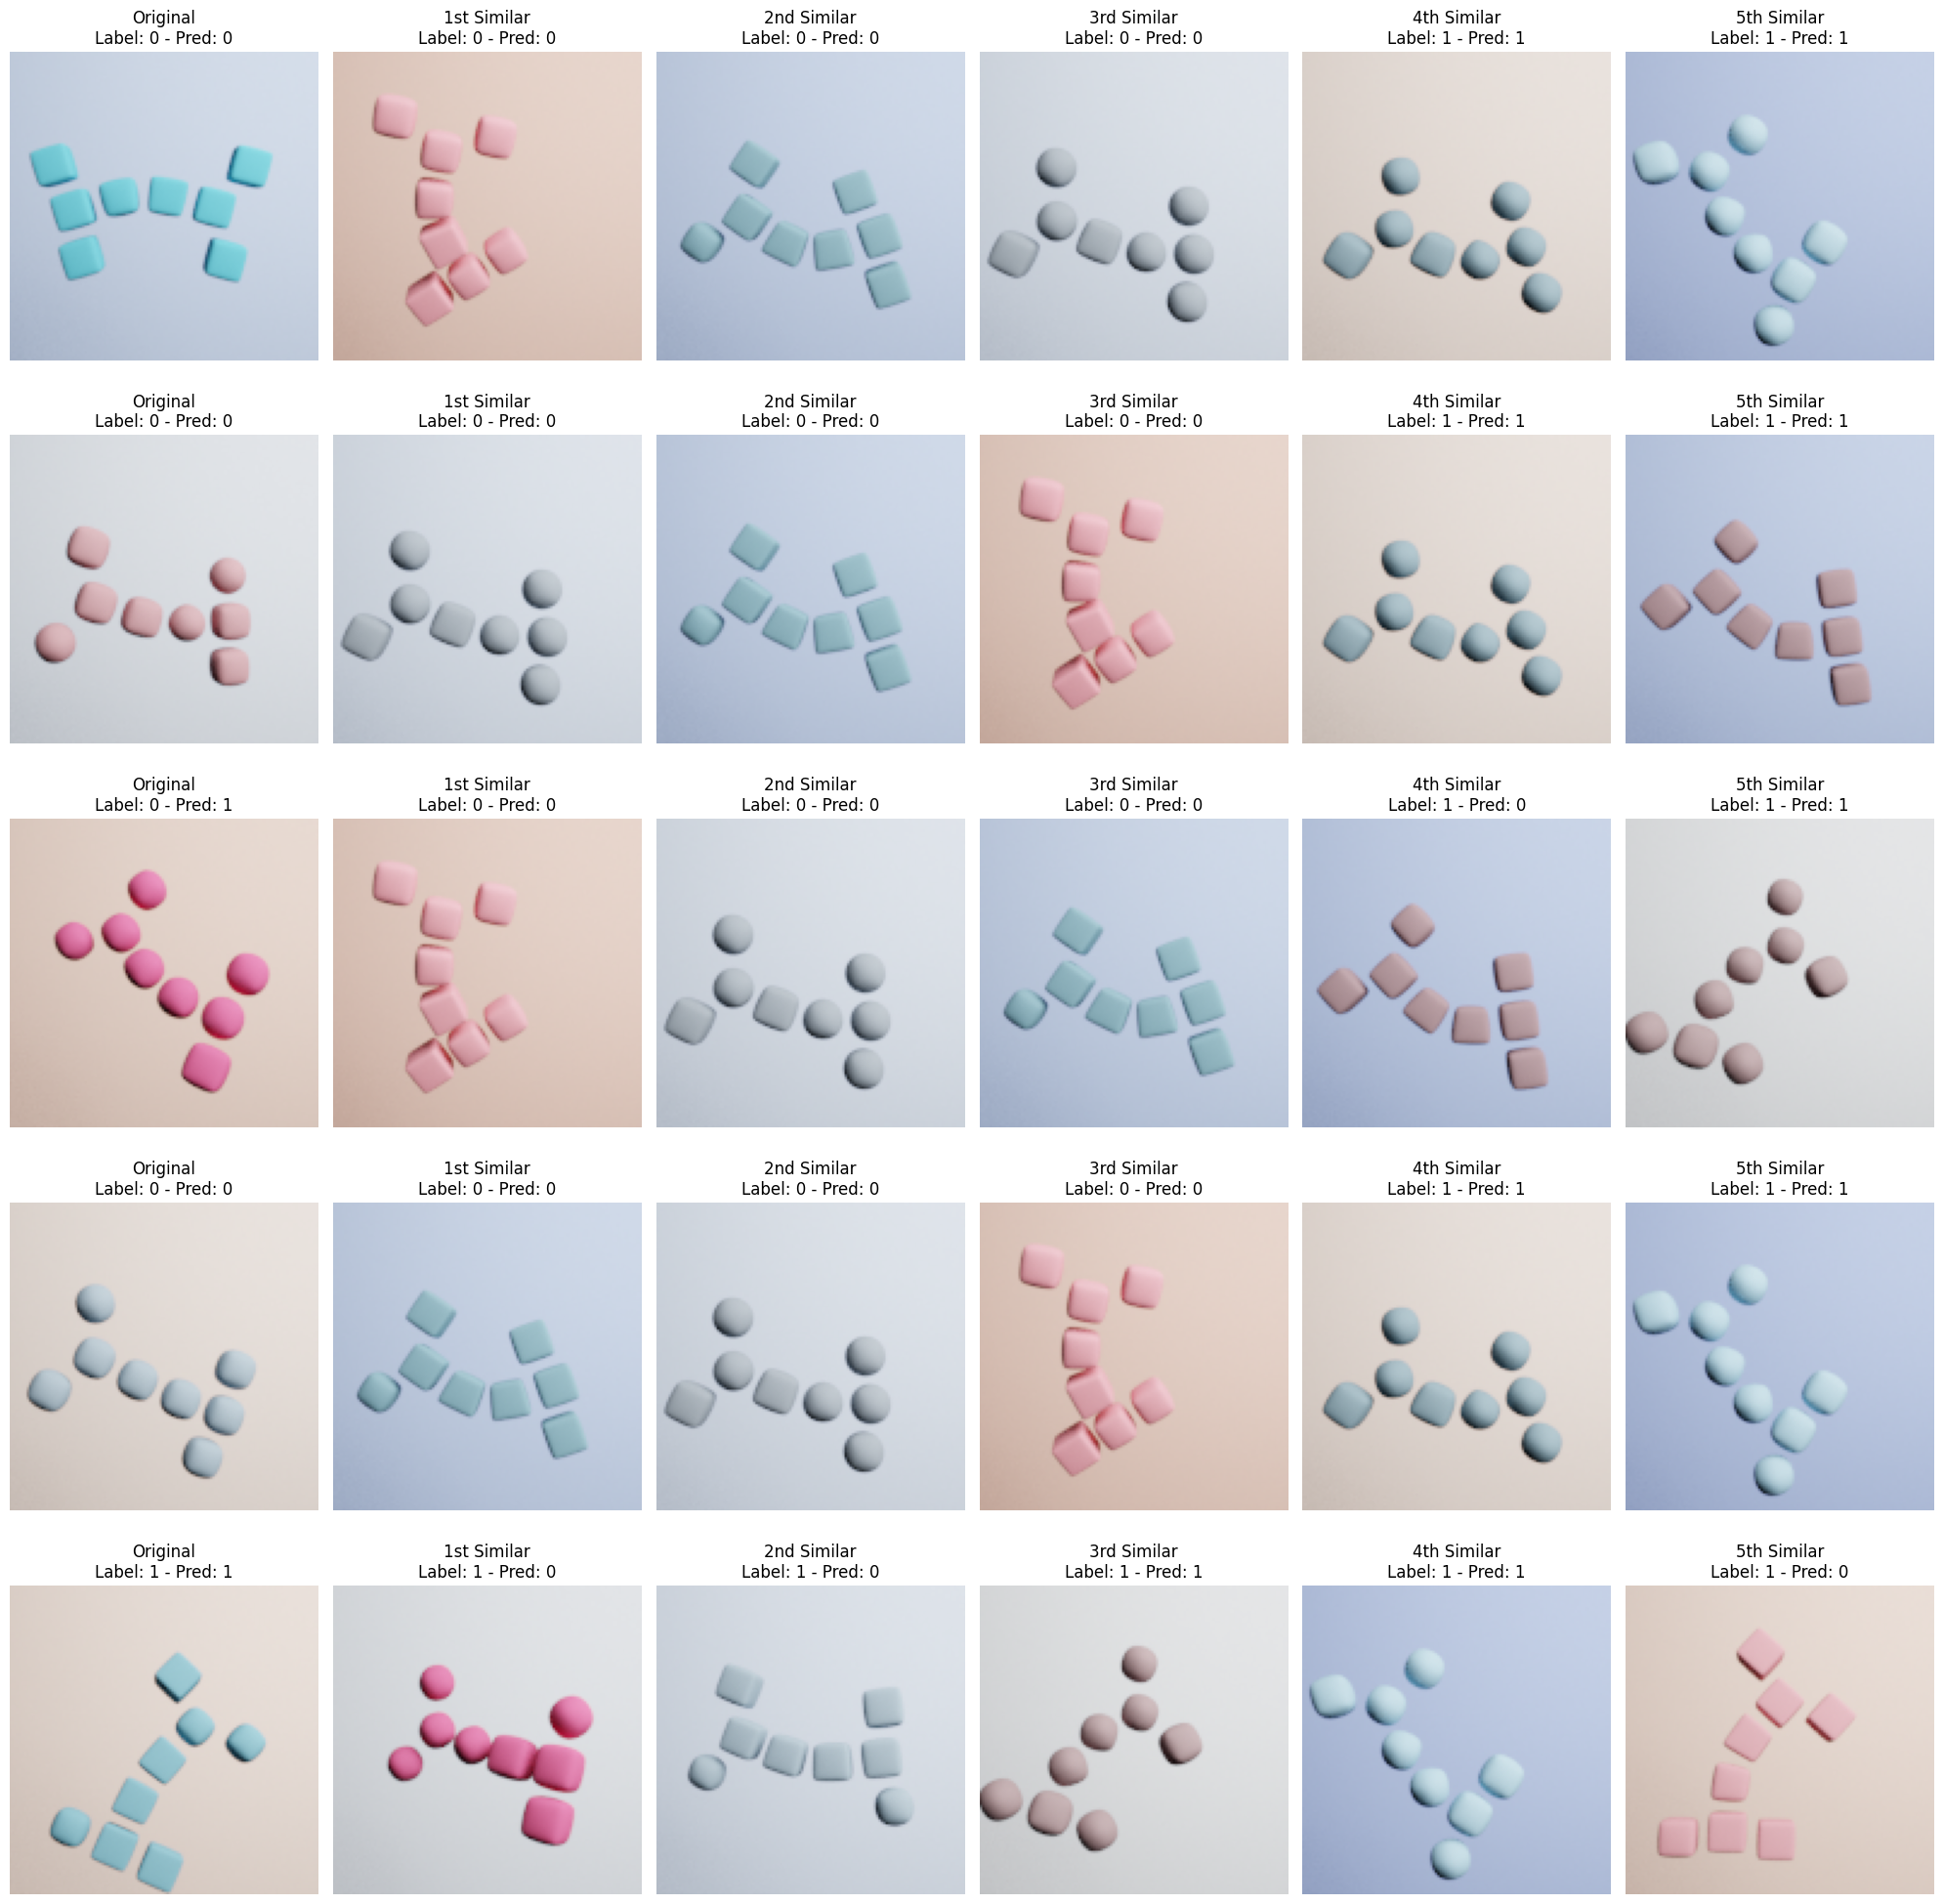

In [52]:
plot_similar(ds, explanation, x_ref)